In [1]:
import pymc3 as pm
import theano.tensor as tt
import theano
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import partial

from skbio.stats.ordination import pcoa, cca
import scipy.spatial.distance
from skbio import DistanceMatrix

%matplotlib inline

def as_col(x):
    if isinstance(x, tt.TensorVariable):
        return x.dimshuffle(0, 'x')
    else:
        return np.asarray(x).reshape(-1, 1)
    
def as_row(x):
    if isinstance(x, tt.TensorVariable):
        return x.dimshuffle('x', 0)
    else:
        return np.asarray(x).reshape(1, -1)
    
def exp(x):
    if isinstance(x, tt.TensorVariable):
        return tt.exp(x)
    else:
        return np.exp(x)
    
def log(x):
    if isinstance(x, tt.TensorVariable):
        return tt.log(x)
    else:
        return np.log(x)

def _ifthen(pred, iftrue, iffalse):
    if pred:
        return iftrue
    else:
        return iffalse

def switch(x, iftrue, iffalse):
    if isinstance(x, tt.TensorVariable):
        return tt.switch(x, iftrue, iffalse)
    else:
        return _ifthen(x, iftrue, iffalse)
    
def lt(x, y):
    if isinstance(x, tt.TensorVariable) or isinstance(y, tt.TensorVariable):
        return tt.lt(x, y)
    else:
        return np.less(x, y)
    
def dot(x, y):
    if isinstance(x, tt.TensorVariable) or isinstance(y, tt.TensorVariable):
        return tt.dot(x, y)
    else:
        return np.dot(x, y)

In [2]:
class DirichletMultinomial(pm.Discrete):
    """Dirichlet Multinomial Distribution

    Parameters
    ----------
    alpha : tensor
        dirichlet parameter

    """
    def __init__(self, alpha, *args, **kwargs):
        super(DirichletMultinomial, self).__init__(*args, **kwargs)
        self.alpha = alpha        

    def logp(self, x):
        gammaln = tt.gammaln
        alpha = self.alpha
        n = x.sum(axis=-1)
        sum_alpha = alpha.sum(axis=-1)

        const = (gammaln(n + 1) + gammaln(sum_alpha)) - gammaln(n + sum_alpha)
        series = gammaln(x + alpha) - (gammaln(x + 1) + gammaln(alpha))
        result = const + series.sum(axis=-1)
        return result


In [3]:
def rv_dm(alpha, n, size=None):
    """Generate samples from the Dirichlet-Multinomial distribution."""
    alpha = np.asarray(alpha)
    assert alpha.ndim == 1
    
    if size is None:
        s = 1
    else:
        s = size
    out = np.empty((s, alpha.shape[0]))
    for i in range(s):
        out[i, :] = sp.random.multinomial(n, sp.random.dirichlet(alpha))
    
    if size is None:
        return out[0,:]
    else:
        return out
    
def norm_simplex(p):
    """Sum-to-zero transformation."""
    return (p.T / p.sum(axis=-1)).T

def backwards_interval(x, a=0, b=1):
    """Backwards interval transformation.
    
    Maps from the whole real line to the interval [0, 1].
    
    """
    return (b - a) * np.exp(x) / (1 + np.exp(x)) + a

def backwards_stickbreaking(p):
    """Backwards stickbreaking transformation.
    
    Maps from a vector of length (k - 1)
    to a k-simplex coordinate.
    
    """
    Km1 = p.shape[0]
    k = np.arange(Km1)[(slice(None), ) + (None, ) * (p.ndim - 1)]
    eq_share = -np.log(Km1 - k)
    z = 1 / (1 + np.exp(-(p + eq_share)))
    p1 = np.concatenate([z, np.ones(p[:1].shape)])
    pu = np.concatenate([np.ones(p[:1].shape), 1 - z])
    S = np.cumprod(pu, 0)
    x = S * p1
    return x

def along_env(comm, pert, env):
    """Generate community composition vector with a proportional perturbation.
    
    Takes 1-d vectors for pert/env instead of 2-d.
    
    See :along_envs:.
    
    """
    pert = switch(lt(pert.ndim, 2), as_row(pert), pert)
    env = switch(lt(env.ndim, 2), as_col(env), env)
    return along_envs(comm, pert, env)

def along_envs(comm, pert, env):
    """Generate community composition vectors with proportional perturbations.
    
    Specifically, the perturbation is applied as the product of
    the base community and the perturbation vectors raised to the power of
    the environmental factor.
    
    comm : tensor (1-d)
        An order-$k$ row-vector
        (treated as though it is on
        the $(k-1)$ unit simplex)
    
    pert : tensor (2-d)
        An order $p \times k$ matrix
        where each row is on the $k-1$ unit
        simplex (sums to 1)
        ($p$ environmental parameters
        $k$ species)
        
    env : tensor (2-d)
        An order $n \times p$ matrix
        ($n$ samples by $p$ environmental
        parameters)
    
    $$
    \frac{\exp(X \dot \log(\Delta) + \log(\pi))}
         {\sum{\exp(X \dot \log(\Delta) + \log(\pi))}}
    $$
    
    Where $X$ is the environmental vector, $\Delta$ is
    the environmental effect matrix, and $\pi$ is the
    basal community (under no environmental impact).
    
    """
    return norm_simplex(exp(dot(env, log(pert)) + log(comm)))

In [4]:
# Set seed
np.random.seed(1)

# Params
comm = norm_simplex(np.array([0.6, 0.2, 0.1, 0.05, 0.05]))
k = len(comm)
m = 10
reps = 100

n = 1000

# Simulation
sim1 = rv_dm(comm * m, n, size=reps)

Applied stickbreaking-transform to pi and added transformed pi_stickbreaking_ to model.
Applied log-transform to mu and added transformed mu_log_ to model.
Assigned NUTS to pi_stickbreaking_
Assigned NUTS to mu_log_
 [-----------------100%-----------------] 1000 of 1000 complete in 4.4 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118da2dd8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x118ec8400>]], dtype=object)

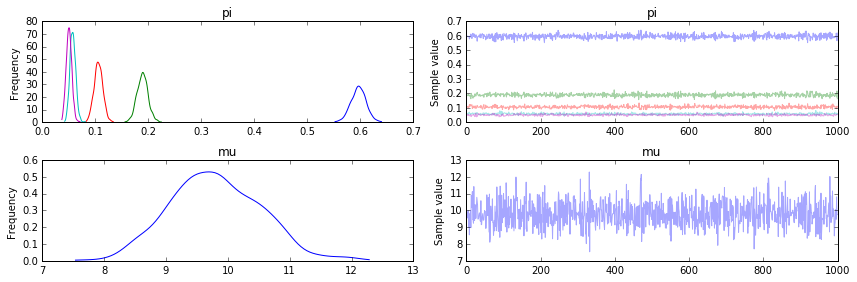

In [5]:
with pm.Model() as model1:
    # Priors
    pi = pm.Dirichlet('pi', np.ones(k))
    mu = pm.Lognormal('mu')
    
    # Observations
    obs = DirichletMultinomial('obs', alpha=pi * mu, observed=sim1)
    
    # Sampling
    start1 = pm.find_MAP()
    trace1 = pm.sample(1e3, start=start1)
    map1 = pm.find_MAP(start=trace1[-1])
    
pm.traceplot(trace1, varnames=['pi', 'mu'])

In [6]:
# TODO: Include a two-environment analysis before the continuous environment
# with an explicit environmental covariate.
# Use the simulation which is already included below.

In [7]:
# Set seed
np.random.seed(0)

# Params
# comm is the intercept
# pert is the "slope" term
log_pert_unnormed = np.array([-2, 0, +1, 0, 0])
pert = norm_simplex(np.exp(log_pert_unnormed))
# An environmental parameter vector
env = np.linspace(0, 1, reps)

# Multiply the community by the perturbation raised
# to the power of the environmental condition
sim2 = np.empty_like(sim1)
for i, e in enumerate(env):
    sim2[i,:] = rv_dm(norm_simplex(comm * pert ** e) * m, n=n)

/Users/bjsmith/Projects/dm-bayes/.venv/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.0010908831753571853 and the largest is 2.0570612628716805.
  RuntimeWarning
/Users/bjsmith/Projects/dm-bayes/.venv/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
/Users/bjsmith/Projects/dm-bayes/.venv/lib/python3.5/site-packages/skbio/stats/ordin

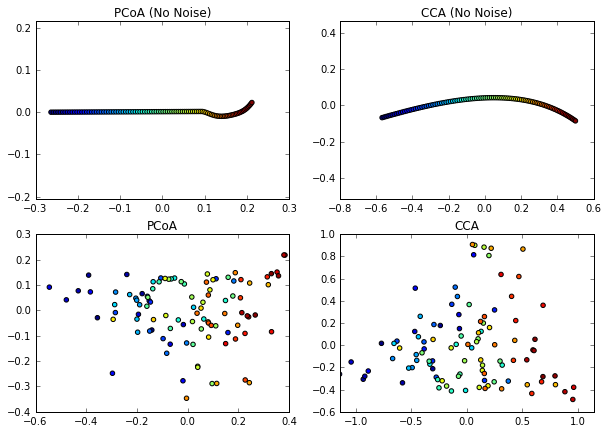

In [8]:
all_comms = along_env(comm, pert, env)

fig, axs = plt.subplots(2, 2, figsize=(10,7))

_ax = axs[0,0]
sim2_clean_dm = DistanceMatrix(scipy.spatial.distance.pdist(all_comms, 'braycurtis'))
sim2_clean_pcoa = pcoa(sim2_clean_dm).samples
_ax.scatter(sim2_clean_pcoa['PC1'], sim2_clean_pcoa['PC2'], c=env)
_ax.set_title('PCoA (No Noise)')

_ax = axs[0,1]
sim2_clean_cca = cca(pd.DataFrame(all_comms), pd.DataFrame(env)).samples
_ax.scatter(sim2_clean_cca.CCA1, sim2_clean_cca.CCA2, c=env)
_ax.set_title('CCA (No Noise)')


_ax = axs[1,0]
sim2_dm = DistanceMatrix(scipy.spatial.distance.pdist(sim2, 'braycurtis'))
sim2_pcoa = pcoa(sim2_dm).samples
_ax.scatter(sim2_pcoa['PC1'], sim2_pcoa['PC2'], c=env)
_ax.set_title('PCoA')

_ax = axs[1,1]
sim2_cca = cca(pd.DataFrame(sim2), pd.DataFrame(env)).samples
_ax.scatter(sim2_cca.CCA1, sim2_cca.CCA2, c=env)
_ax.set_title('CCA')

for _ax in axs.flatten():
    _ax.set_aspect('equal', adjustable='datalim')
    
# TODO: Remove the CCA, only include PCoA

Applied stickbreaking-transform to pi and added transformed pi_stickbreaking_ to model.
Applied log-transform to mu and added transformed mu_log_ to model.
Applied stickbreaking-transform to delta and added transformed delta_stickbreaking_ to model.
Assigned NUTS to pi_stickbreaking_
Assigned NUTS to mu_log_
Assigned NUTS to delta_stickbreaking_
 [-----------------100%-----------------] 1000 of 1000 complete in 23.4 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11bbe2fd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11bea3898>]], dtype=object)

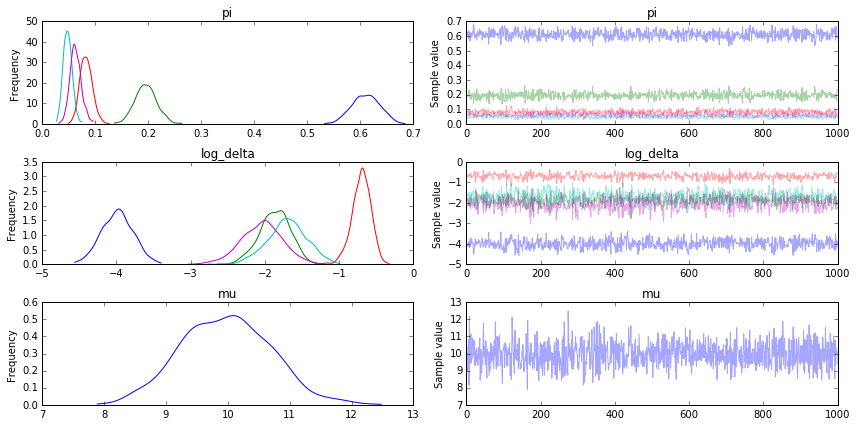

In [9]:
with pm.Model() as model2:
    # Priors
    pi = pm.Dirichlet('pi', np.ones(k))
    mu = pm.Lognormal('mu')
    delta = pm.Dirichlet('delta', np.ones(k))
    
    # Observations
    obs = DirichletMultinomial('obs',
                               alpha=along_env(pi, delta, env) * mu,
                               observed=sim2)
    
    # Estimators
    log_delta = pm.Deterministic('log_delta', tt.log(delta))

    # Sampling
    start2 = pm.find_MAP()
    trace2 = pm.sample(1e3, start=start2)
    map2 = pm.find_MAP(start=trace2[-1])
    
pm.traceplot(trace2, varnames=['pi', 'log_delta', 'mu'])

In [10]:
# Set seed
np.random.seed(1)

# the intensity of the difference
diff = 1

# Multiply the community by the perturbation raised
# to the power of the difference
sim3 = np.row_stack([rv_dm(comm * m,
                           n,
                           size=reps // 2),
                     rv_dm(norm_simplex(comm * pert ** diff) * m,
                           n,
                           size=reps // 2)])

/Users/bjsmith/Projects/dm-bayes/.venv/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.3862300307055648 and the largest is 7.276508409063109.
  RuntimeWarning


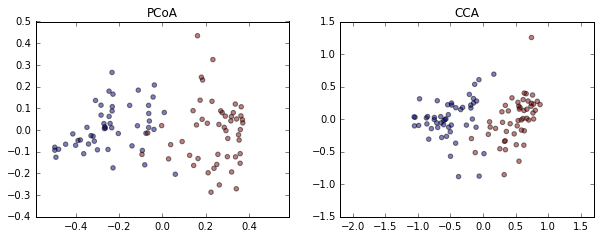

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10,3.5))

_env = [0] * (reps // 2) + [1] * (reps // 2)

_ax = axs[0]
sim3_dm = DistanceMatrix(scipy.spatial.distance.pdist(sim3, 'braycurtis'))
sim3_pcoa = pcoa(sim3_dm).samples
_ax.scatter(sim3_pcoa['PC1'], sim3_pcoa['PC2'], c=_env, alpha=0.5)
_ax.set_title('PCoA')

_ax = axs[1]
sim3_cca = cca(pd.DataFrame(sim3), pd.DataFrame(_env)).samples
_ax.scatter(sim3_cca.CCA1, sim3_cca.CCA2, c=_env, alpha=0.5)
_ax.set_title('CCA')

for _ax in axs.flatten():
    _ax.set_aspect('equal', adjustable='datalim')

Applied log-transform to mixture_hyper_hyper and added transformed mixture_hyper_hyper_log_ to model.
Applied logodds-transform to mixture_hyper and added transformed mixture_hyper_logodds_ to model.
Applied stickbreaking-transform to pi and added transformed pi_stickbreaking_ to model.
Applied log-transform to mu and added transformed mu_log_ to model.
Assigned NUTS to mixture_hyper_hyper_log_
Assigned NUTS to mixture_hyper_logodds_
Assigned NUTS to pi_stickbreaking_
Assigned NUTS to mu_log_
Assigned ElemwiseCategorical to x
 [-----------------100%-----------------] 5000 of 5000 complete in 574.5 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11eaf1eb8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11f3a2b38>]], dtype=object)

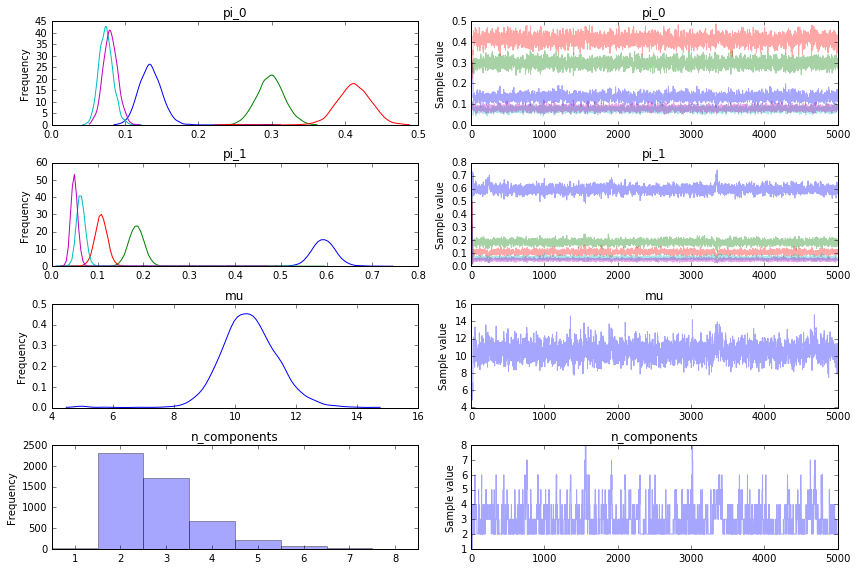

In [12]:
max_components = 10
with pm.Model() as model3:
    # Priors
    mixture_hyper_hyper = pm.Gamma('mixture_hyper_hyper', 1., 1.)
    mixture_hyper = pm.Beta('mixture_hyper', 1., mixture_hyper_hyper, shape=max_components)
    mixture_probs = pm.Deterministic('mixture_probs',
            mixture_hyper * tt.concatenate([[1], tt.extra_ops.cumprod(1 - mixture_hyper)[:-1]]))
    
    pi = pm.Dirichlet('pi', np.ones(k), shape=(max_components, k))
    mu = pm.Lognormal('mu')
    
    # Latent variables
    x = pm.Categorical('x', mixture_probs, shape=reps)
    
    # Observations
    obs = DirichletMultinomial('obs', alpha=pi[x] * mu, observed=sim3)
    
    # Estimators
    n_components = pm.Deterministic('n_components',
                                    tt.extra_ops.bincount(x).nonzero(return_matrix=True).shape[-1])
    pi_0 = pm.Deterministic('pi_0', pi[0])
    pi_1 = pm.Deterministic('pi_1', pi[1])
    pi_2 = pm.Deterministic('pi_2', pi[2])

    # Sampling
    start3 = pm.find_MAP(vars=model3.vars)
    trace3 = pm.sample(5e3, start=start3)
    map3 = pm.find_MAP(start=trace3[-1], vars=model3.vars)
    
pm.traceplot(trace3, varnames=['pi_0', 'pi_1', 'mu', 'n_components'])

Applied stickbreaking-transform to pi and added transformed pi_stickbreaking_ to model.
Applied log-transform to mu and added transformed mu_log_ to model.
Applied stickbreaking-transform to delta and added transformed delta_stickbreaking_ to model.
Applied interval-transform to x and added transformed x_interval_ to model.
Assigned NUTS to pi_stickbreaking_
Assigned NUTS to mu_log_
Assigned NUTS to delta_stickbreaking_
Assigned NUTS to x_interval_
 [-----------------100%-----------------] 1000 of 1000 complete in 119.7 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122374e48>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12260a6d8>]], dtype=object)

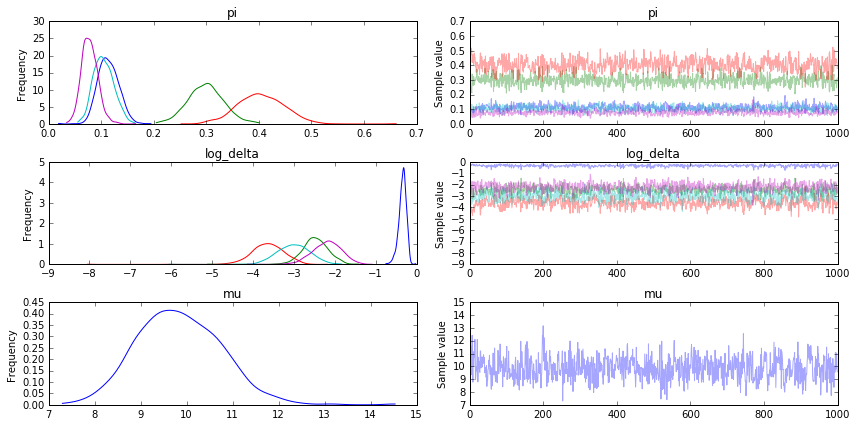

In [13]:
with pm.Model() as model4:
    # Priors
    pi = pm.Dirichlet('pi', np.ones(k))
    mu = pm.Lognormal('mu')
    delta = pm.Dirichlet('delta', np.ones(k))
    
    # Latent variables
    x = pm.Uniform('x', 0, 1, shape=reps)
    
    # Observations
    obs = DirichletMultinomial('obs',
                               alpha=along_env(pi, delta, x) * mu,
                               observed=sim2)
        
    # Estimators
    log_delta = pm.Deterministic('log_delta', tt.log(delta))

    # Sampling
    start4 = pm.find_MAP()
    trace4 = pm.sample(1e3, start=start4)
    map4 = pm.find_MAP(start=trace4[-1])
    
pm.traceplot(trace4, varnames=['pi', 'log_delta', 'mu'])

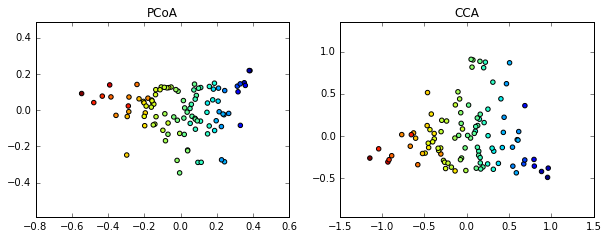

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10,3.5))

_env = backwards_interval(map4['x_interval_'])

_ax = axs[0]
_ax.scatter(sim2_pcoa['PC1'], sim2_pcoa['PC2'], c=_env)
_ax.set_title('PCoA')

_ax = axs[1]
_ax.scatter(sim2_cca.CCA1, sim2_cca.CCA2, c=_env)
_ax.set_title('CCA')

for _ax in axs.flatten():
    _ax.set_aspect('equal', adjustable='datalim')

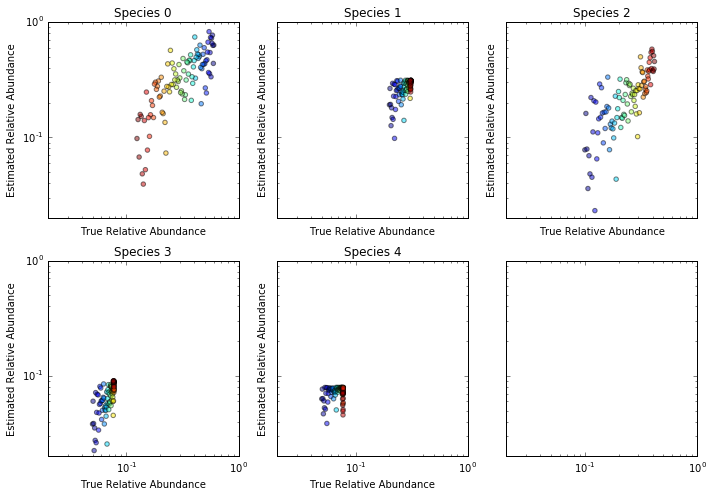

In [15]:
delta_map4 = backwards_stickbreaking(map4['delta_stickbreaking_'])
pi_map4 = backwards_stickbreaking(map4['pi_stickbreaking_'])
x_map4 = backwards_interval(map4['x_interval_'])
all_comms_map4 = along_env(pi_map4, delta_map4, x_map4)

fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex=True, sharey=True)

for i, ax in zip(range(k), axs.flatten()):
    ax.scatter(all_comms[:,i], all_comms_map4[:,i], c=env, alpha=0.5)
    ax.set_xlabel('True Relative Abundance')
    ax.set_ylabel('Estimated Relative Abundance')
    ax.set_title('Species %d' % i)
    ax.set_xscale('log')
    ax.set_yscale('log')
ax.set_xlim((0.02, 1))
ax.set_ylim((0.02, 1))
fig.tight_layout()

Applied stickbreaking-transform to pi and added transformed pi_stickbreaking_ to model.
Applied log-transform to mu and added transformed mu_log_ to model.
Applied stickbreaking-transform to delta and added transformed delta_stickbreaking_ to model.
Applied interval-transform to x and added transformed x_interval_ to model.
Assigned NUTS to pi_stickbreaking_
Assigned NUTS to mu_log_
Assigned NUTS to delta_stickbreaking_
Assigned NUTS to x_interval_
 [-----------------100%-----------------] 1000 of 1000 complete in 99.2 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x121151828>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x124d9ec88>]], dtype=object)

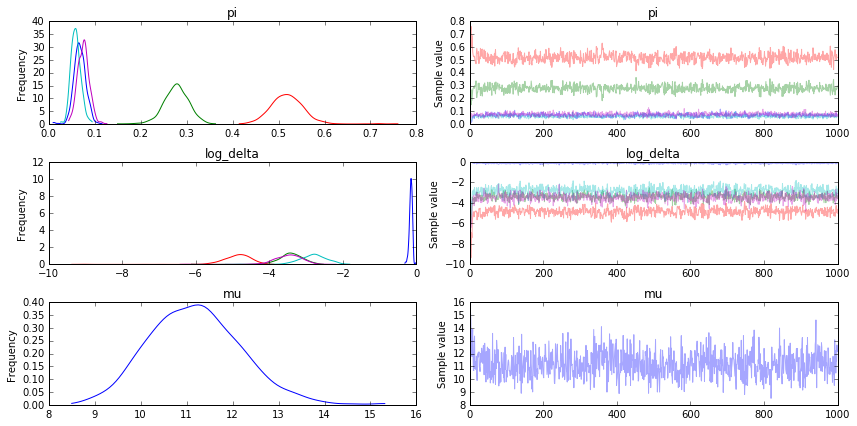

In [16]:
# Misspecified

with pm.Model() as model5:
    # Priors
    pi = pm.Dirichlet('pi', np.ones(k))
    mu = pm.Lognormal('mu')
    delta = pm.Dirichlet('delta', np.ones(k))
    
    # Latent variables
    x = pm.Uniform('x', 0, 1, shape=reps)
    
    # Observations
    obs = DirichletMultinomial('obs',
                               alpha=along_env(pi, delta, x) * mu,
                               observed=sim3)
        
    # Estimators
    log_delta = pm.Deterministic('log_delta', tt.log(delta))

    # Sampling
    start5 = pm.find_MAP()
    trace5 = pm.sample(1e3, start=start5)
    map5 = pm.find_MAP(start=trace5[-1])
    
pm.traceplot(trace5, varnames=['pi', 'log_delta', 'mu'])

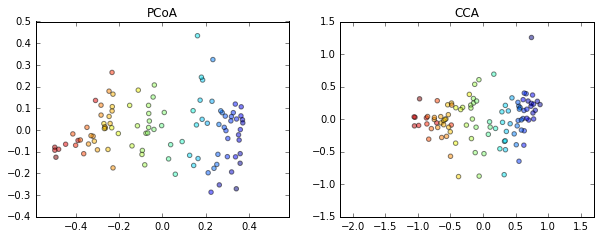

In [17]:
x_map5 = backwards_interval(map5['x_interval_'])

fig, axs = plt.subplots(1, 2, figsize=(10,3.5))

_env = [0] * (reps // 2) + [1] * (reps // 2)

_ax = axs[0]
_ax.scatter(sim3_pcoa['PC1'], sim3_pcoa['PC2'], c=x_map5, alpha=0.5)
_ax.set_title('PCoA')

_ax = axs[1]
_ax.scatter(sim3_cca.CCA1, sim3_cca.CCA2, c=x_map5, alpha=0.5)
_ax.set_title('CCA')

for _ax in axs.flatten():
    _ax.set_aspect('equal', adjustable='datalim')

Applied log-transform to mixture_hyper_hyper and added transformed mixture_hyper_hyper_log_ to model.
Applied logodds-transform to mixture_hyper and added transformed mixture_hyper_logodds_ to model.
Applied stickbreaking-transform to pi and added transformed pi_stickbreaking_ to model.
Applied log-transform to mu and added transformed mu_log_ to model.
Assigned NUTS to mixture_hyper_hyper_log_
Assigned NUTS to mixture_hyper_logodds_
Assigned NUTS to pi_stickbreaking_
Assigned NUTS to mu_log_
Assigned ElemwiseCategorical to x
 [-----------------100%-----------------] 1000 of 1000 complete in 130.5 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x128cd9828>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x128f68ef0>]], dtype=object)

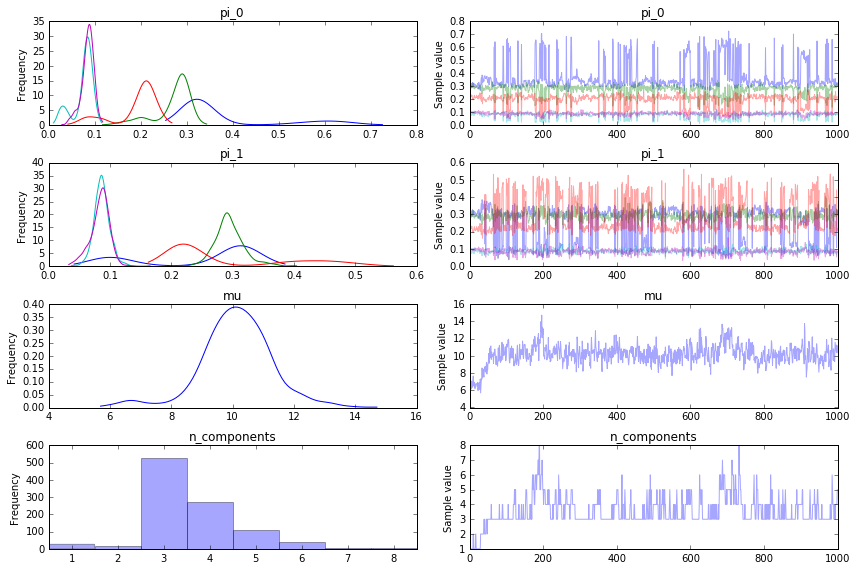

In [18]:
# Misspecified

max_components = 10
with pm.Model() as model6:
    # Priors
    mixture_hyper_hyper = pm.Gamma('mixture_hyper_hyper', 1., 1.)
    mixture_hyper = pm.Beta('mixture_hyper', 1., mixture_hyper_hyper, shape=max_components)
    mixture_probs = pm.Deterministic('mixture_probs',
            mixture_hyper * tt.concatenate([[1], tt.extra_ops.cumprod(1 - mixture_hyper)[:-1]]))
    
    pi = pm.Dirichlet('pi', np.ones(k), shape=(max_components, k))
    mu = pm.Lognormal('mu')
    
    # Latent variables
    x = pm.Categorical('x', mixture_probs, shape=reps)
    
    # Observations
    obs = DirichletMultinomial('obs', alpha=pi[x] * mu, observed=sim2)
    
    # Estimators
    n_components = pm.Deterministic('n_components',
                                    tt.extra_ops.bincount(x).nonzero(return_matrix=True).shape[-1])
    
    early_class = tt.extra_ops.to_one_hot(x[0:20], max_components).sum(axis=0).argmax()
    late_class = tt.extra_ops.to_one_hot(x[80:100], max_components).sum(axis=0).argmax()
    pi_0 = pm.Deterministic('pi_0', pi[early_class])
    pi_1 = pm.Deterministic('pi_1', pi[late_class])

    # Sampling
    start6 = pm.find_MAP(vars=model6.vars)
    trace6 = pm.sample(1e3, start=start6)
    map6 = pm.find_MAP(start=trace6[-1], vars=model6.vars)
    
pm.traceplot(trace6, varnames=['pi_0', 'pi_1', 'mu', 'n_components'])

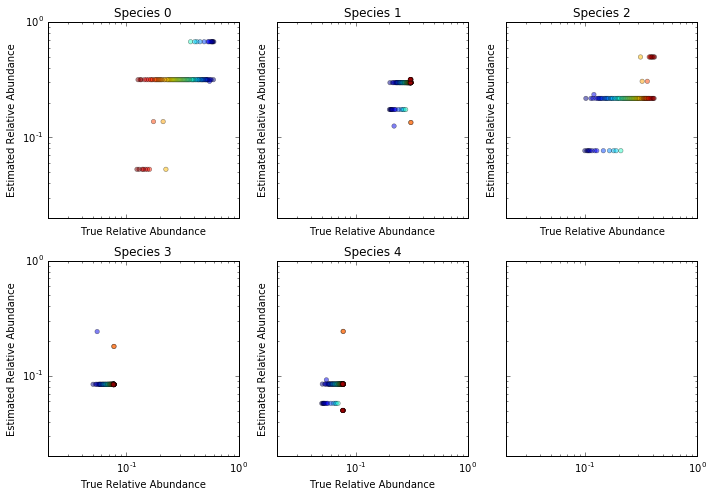

In [19]:
pi_map6 = np.apply_along_axis(backwards_stickbreaking, 1, map6['pi_stickbreaking_'])
x_map6 = map6['x']
all_comms_map6 = pi_map6[x_map6,:]

fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex=True, sharey=True)

for i, ax in zip(range(k), axs.flatten()):
    ax.scatter(all_comms[:,i], all_comms_map6[:,i], c=env, alpha=0.5, lw=0.5)
    ax.set_xlabel('True Relative Abundance')
    ax.set_ylabel('Estimated Relative Abundance')
    ax.set_title('Species %d' % i)
    ax.set_xscale('log')
    ax.set_yscale('log')
ax.set_xlim((0.02, 1))
ax.set_ylim((0.02, 1))
fig.tight_layout()

In [20]:
np.random.seed(0)

log_pert_unnormed_1 = np.array([-2, 0, +1, 0, 0])
log_pert_unnormed_2 = np.array([+1, +1, 0, 0, 0])
pert_1 = norm_simplex(np.exp(log_pert_unnormed_1))
pert_2 = norm_simplex(np.exp(log_pert_unnormed_2))

env_1 = np.random.uniform(size=reps)
env_2 = np.random.uniform(size=reps)

sim4 = np.empty_like(sim1)
for i, (e1, e2) in enumerate(zip(env_1, env_2)):
    sim4[i,:] = rv_dm(norm_simplex(comm * pert_1 ** e1 * pert_2 ** e2) * m, n=n)

/Users/bjsmith/Projects/dm-bayes/.venv/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.36044999457117566 and the largest is 3.6781234855723373.
  RuntimeWarning
/Users/bjsmith/Projects/dm-bayes/.venv/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section fo

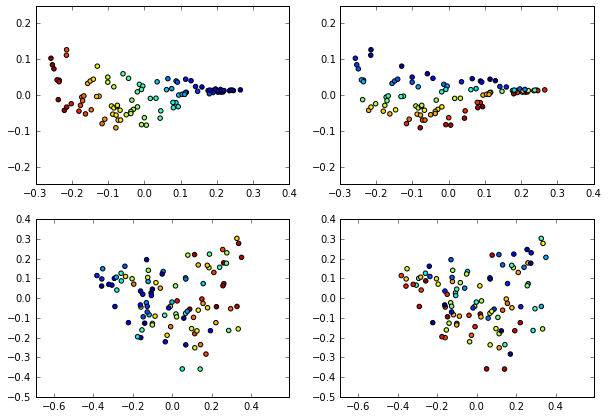

In [21]:
all_comms_sim4 = along_env(comm,
                           np.row_stack([pert_1, pert_2]),
                           np.column_stack([env_1, env_2]))

fig, axs = plt.subplots(2, 2, figsize=(10, 7))

sim4_pcoa = pcoa(DistanceMatrix(scipy.spatial.distance.pdist(sim4, 'braycurtis'))).samples
sim4_clean_pcoa = pcoa(DistanceMatrix(scipy.spatial.distance.pdist(all_comms_sim4, 'braycurtis'))).samples

for _pcoa, ax_row in zip([sim4_clean_pcoa, sim4_pcoa], axs):
    for e, ax in zip([env_1, env_2], ax_row):
        ax.scatter(_pcoa.PC1, _pcoa.PC2, c=e)
        ax.set_aspect('equal', adjustable='datalim')

Applied stickbreaking-transform to pi and added transformed pi_stickbreaking_ to model.
Applied log-transform to mu and added transformed mu_log_ to model.
Applied stickbreaking-transform to delta and added transformed delta_stickbreaking_ to model.
Applied interval-transform to x and added transformed x_interval_ to model.
Assigned NUTS to pi_stickbreaking_
Assigned NUTS to mu_log_
Assigned NUTS to delta_stickbreaking_
Assigned NUTS to x_interval_
 [-----------------100%-----------------] 1001 of 1000 complete in 201.7 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12c6c8780>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12ca31c88>]], dtype=object)

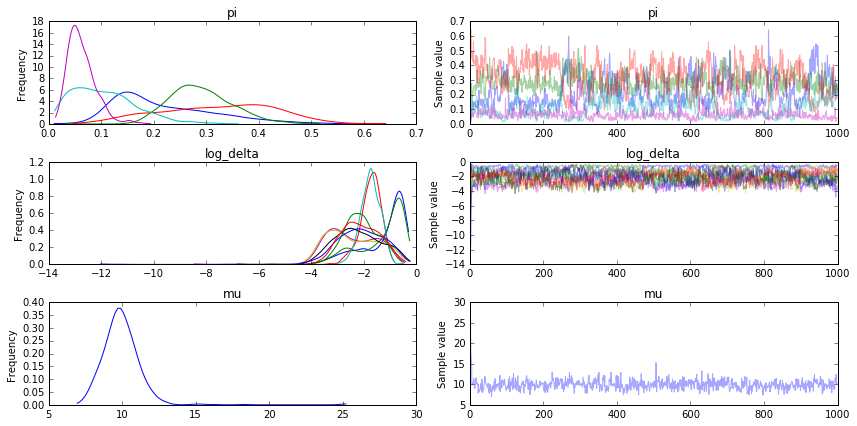

In [22]:
with pm.Model() as model7:
    # Priors
    pi = pm.Dirichlet('pi', np.ones(k))
    mu = pm.Lognormal('mu')
    delta = pm.Dirichlet('delta', np.ones(k), shape=(2, k))
    
    # Latent variables
    x = pm.Uniform('x', 0, 1, shape=(reps, 2))
    
    # Observations
    obs = DirichletMultinomial('obs',
                               alpha=along_envs(pi, delta, x) * mu,
                               observed=sim4)
        
    # Estimators
    # TODO: Find the eigenvectors/values of this matrix as
    # a way to compare it to the initial perturbation matrix.
    log_delta = pm.Deterministic('log_delta', tt.log(delta))

    # Sampling
    start7 = pm.find_MAP(vars=model7.vars)
    trace7 = pm.sample(1e3, start=start7)
    map7 = pm.find_MAP(start=trace7[-1])
    
pm.traceplot(trace7, varnames=['pi', 'log_delta', 'mu'])

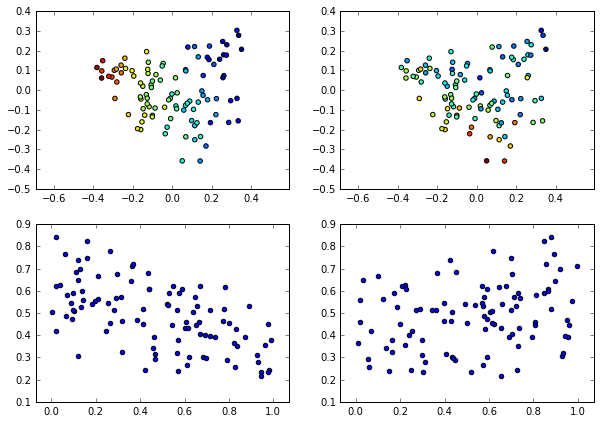

In [23]:
x_map7 = backwards_interval(map7['x_interval_'])


fig, axs = plt.subplots(2, 2, figsize=(10, 7))

_ax = axs[0,0]
_ax.scatter(sim4_pcoa.PC1, sim4_pcoa.PC2, c=x_map7[:,0])

_ax = axs[0,1]
_ax.scatter(sim4_pcoa.PC1, sim4_pcoa.PC2, c=x_map7[:,1])

_ax = axs[1,0]
_ax.scatter(env_1, x_map7[:,0])

_ax = axs[1,1]
_ax.scatter(env_2, x_map7[:,0])


for _ax in axs.flatten():
    _ax.set_aspect('equal', adjustable='datalim')

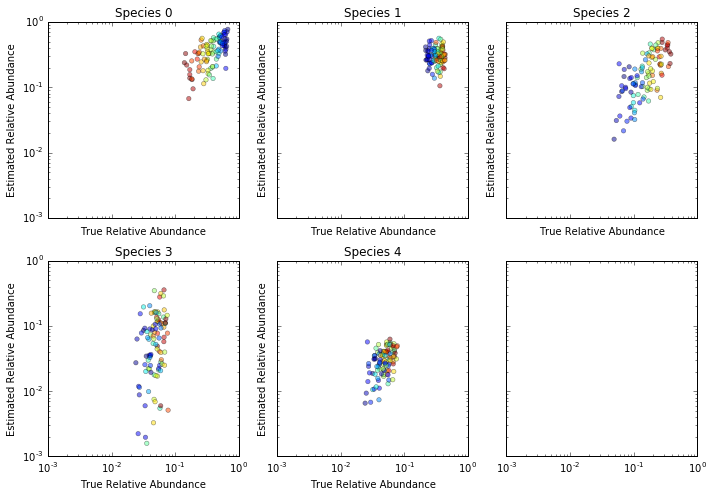

In [24]:
pi_map7 = backwards_stickbreaking(map7['pi_stickbreaking_'])
delta_map7 = np.apply_along_axis(backwards_stickbreaking, 1, map7['delta_stickbreaking_'])

all_comms_map7 = along_env(pi_map7, delta_map7, x_map7)

fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex=True, sharey=True)

for i, ax in zip(range(k), axs.flatten()):
    ax.scatter(all_comms_sim4[:,i], all_comms_map7[:,i], c=env_1, alpha=0.5, lw=0.5)
    ax.set_xlabel('True Relative Abundance')
    ax.set_ylabel('Estimated Relative Abundance')
    ax.set_title('Species %d' % i)
    ax.set_xscale('log')
    ax.set_yscale('log')
ax.set_xlim((0.001, 1))
ax.set_ylim((0.001, 1))
fig.tight_layout()

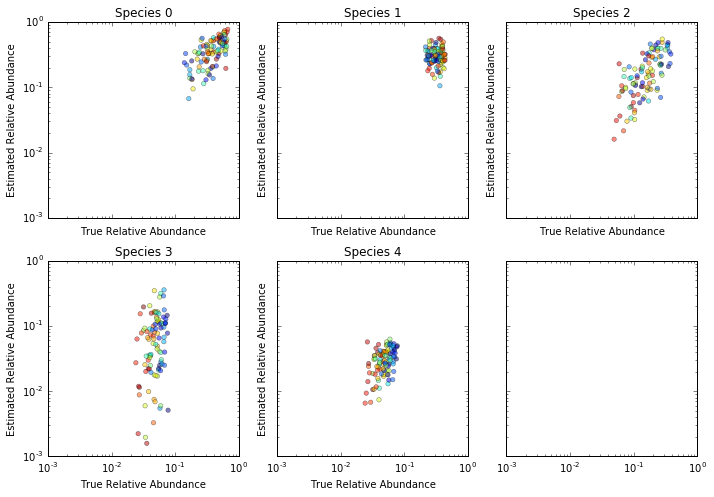

In [25]:
fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex=True, sharey=True)

for i, ax in zip(range(k), axs.flatten()):
    ax.scatter(all_comms_sim4[:,i], all_comms_map7[:,i], c=env_2, alpha=0.5, lw=0.5)
    ax.set_xlabel('True Relative Abundance')
    ax.set_ylabel('Estimated Relative Abundance')
    ax.set_title('Species %d' % i)
    ax.set_xscale('log')
    ax.set_yscale('log')
ax.set_xlim((0.001, 1))
ax.set_ylim((0.001, 1))
fig.tight_layout()